**Program**: 5_NSCH_Naive_Bayes_Analysis<br>
**Class**: Fall 2025, Machine Learning, Project<br>
**Member**: Vanessa Thorsten<br>
**Description**: This program reads in the analysis dataset NSCH_fam.csv, which provides data at the child-level and requires weighting the data due to the sampling and response. Variables are kept and Random Forest analysis is performed.<br>
<br>
**Outputs**: The following data visualizations are provided for the dataset:<br>
'Q9_AdeqSleep_BNB_features.png'<br>
'Q9_AdeqSleep_BNB_CM.png'<br>
'Q9_AdeqSleep_BNB_ROC.png'<br>
'Q9_AdeqSleep_BNB_LogDiff.png'<br>
<br>
**Program History/Modifications**:<br>
10/14/2025    Initial Version

In [1]:
# Importing the libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score, f1_score, recall_score, classification_report
from sklearn.metrics import make_scorer #use for weighted roc auc
from sklearn.tree import plot_tree

from sklearn.inspection import PartialDependenceDisplay

In [2]:
#Combined state level data
df_fam = pd.read_csv("NSCH_fam.csv")
df_fam.head()

,Unnamed: 0,FIPSST,STATE,STATE_NAME,STRATUM,HHID,FORMTYPE,TOTKIDS_R,FWC,SC_AGE_YEARS,...,K4Q01,GOWHENSICK,UsualSck_23,smAdeqIns_23,smForgoneHC_23,nomAnxietyDep12to17_23,nomFlrish6mto5_23,nomFlrish6to17_23,ScreenTime_23,HrsSleep_23
0,0,6,CA,California,1,23043707,2,1,1318.476840,11,...,2.0,NaN,2.0,1.0,2.0,NaN,90.0,2.0,4.0,2.0
1,1,6,CA,California,1,23120547,3,2,978.499881,14,...,1.0,1.0,1.0,1.0,2.0,2.0,90.0,1.0,5.0,1.0
2,2,6,CA,California,1,23197456,3,1,904.191765,17,...,1.0,NaN,NaN,1.0,2.0,2.0,90.0,1.0,4.0,1.0
3,3,6,CA,California,1,23197458,3,2,1092.097256,12,...,1.0,1.0,1.0,1.0,2.0,2.0,90.0,1.0,4.0,1.0
4,4,6,CA,California,1,23235909,2,2,586.387870,10,...,2.0,NaN,2.0,2.0,2.0,NaN,90.0,1.0,5.0,1.0


In [3]:
df_fam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54159 entries, 0 to 54158
Data columns (total 44 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              54159 non-null  int64  
 1   FIPSST                  54159 non-null  int64  
 2   STATE                   54159 non-null  object 
 3   STATE_NAME              54159 non-null  object 
 4   STRATUM                 54159 non-null  int64  
 5   HHID                    54159 non-null  int64  
 6   FORMTYPE                54159 non-null  int64  
 7   TOTKIDS_R               54159 non-null  int64  
 8   FWC                     54159 non-null  float64
 9   SC_AGE_YEARS            54159 non-null  int64  
 10  SC_SEX                  54159 non-null  int64  
 11  age3_23                 54159 non-null  int64  
 12  age5_23                 54159 non-null  int64  
 13  sex_23                  54159 non-null  int64  
 14  hispanic_23             54159 non-null

In [4]:
# Outcome of interest is teens geeting adequate sleep for their age.
# Filter the data to teens
df_teen = df_fam[df_fam['SC_AGE_YEARS'] > 12].copy()

In [5]:
#Add labeled variable for graphs
hrssleep_labels = {
    1: 'Adequate for age',
    2: 'Inadequate for age'
}

hrssleep_order = ['Adequate for age', 'Inadequate for age']

df_teen['HrsSleep_labeled'] = df_teen['HrsSleep_23'].map(hrssleep_labels)

#Add 0/1 variable for models. 1 -> 0 (adequate sleep), 2 -> 1 (inadequate sleep), NAN stays NAN
df_teen['inadequate_sleep'] = df_teen['HrsSleep_23'].map({1: 0, 2: 1}).astype('Int64')

In [6]:
cols = ['HrsSleep_23', 'inadequate_sleep', 'ScreenTime_23', 'SC_AGE_YEARS', 'HousingInstab_23',
        'FoodCash_23', 'smAdeqIns_23', 'nomChHlthSt_23', 'PrevMed_23', 'K4Q01']

for col in cols:
    print(f"{df_teen[col].value_counts()}\n")

# FoodCash_23 is 1= someone in house received food/cash assistance during the past 12 months from 3-5 sources
#                2= someone in house received food/cash assistance during the past 12 months from 1-2 sources
#                3= did not receive food/cash assistance during the past 12 months


HrsSleep_23
1.0    10980
2.0     4272
Name: count, dtype: int64

inadequate_sleep
0    10980
1     4272
Name: count, dtype: Int64

ScreenTime_23
5.0    5631
3.0    3956
4.0    3943
2.0    1211
1.0     468
Name: count, dtype: int64

SC_AGE_YEARS
16    3453
17    3370
15    3099
14    2741
13    2728
Name: count, dtype: int64

HousingInstab_23
2.0    13013
1.0     2113
Name: count, dtype: int64

FoodCash_23
1.0    10105
2.0     4015
3.0     1002
Name: count, dtype: int64

smAdeqIns_23
1.0    9814
2.0    5577
Name: count, dtype: int64

nomChHlthSt_23
1.0    13608
2.0     1783
Name: count, dtype: int64

PrevMed_23
1.0    11667
2.0     3724
Name: count, dtype: int64

K4Q01
1.0    12650
2.0     2741
Name: count, dtype: int64



In [7]:
# Using isna() to count NaNs in each column
column_nan_count_isna = df_teen[['HrsSleep_23', 'ScreenTime_23', 'SC_AGE_YEARS', 'HousingInstab_23', 'FoodCash_23', 
'smAdeqIns_23', 'nomChHlthSt_23', 'PrevMed_23', 'K4Q01', 'FWC']].isna().sum()
print("NaN count per column using isna():") 
print(column_nan_count_isna)

NaN count per column using isna():
HrsSleep_23         139
ScreenTime_23       182
SC_AGE_YEARS          0
HousingInstab_23    265
FoodCash_23         269
smAdeqIns_23          0
nomChHlthSt_23        0
PrevMed_23            0
K4Q01                 0
FWC                   0
dtype: int64


In [8]:
# Subset to relevant variables
df_teen_rf = df_teen[['inadequate_sleep', 'HrsSleep_23', 'HrsSleep_labeled', 'ScreenTime_23', 'SC_AGE_YEARS', 'HousingInstab_23',
                      'FoodCash_23', 'smAdeqIns_23', 'nomChHlthSt_23', 'PrevMed_23',
                      'K4Q01', 'FWC']].copy()

# Fill missing values with the mode (most frequent value) for each column
for col in df_teen_rf.columns:
    mode = df_teen_rf[col].mode(dropna=True)
    if not mode.empty:
        df_teen_rf[col] = df_teen_rf[col].fillna(mode[0])
    else:
        print(f"Warning: No mode found for column '{col}' — possibly all NaNs.")


In [9]:
#convert from float to int
cols_to_convert = ['HrsSleep_23', 'ScreenTime_23', 'HousingInstab_23',
                   'FoodCash_23', 'smAdeqIns_23', 'nomChHlthSt_23',
                   'PrevMed_23', 'K4Q01']

df_teen_rf[cols_to_convert] = df_teen_rf[cols_to_convert].astype('int64')

In [10]:
column_nan_count_isna = df_teen_rf[['inadequate_sleep', 'HrsSleep_23', 'ScreenTime_23', 'SC_AGE_YEARS', 'HousingInstab_23', 'FoodCash_23', 
'smAdeqIns_23', 'nomChHlthSt_23', 'PrevMed_23', 'K4Q01', 'FWC']].isna().sum()
print("NaN count per column using isna():") 
print(column_nan_count_isna)

NaN count per column using isna():
inadequate_sleep    0
HrsSleep_23         0
ScreenTime_23       0
SC_AGE_YEARS        0
HousingInstab_23    0
FoodCash_23         0
smAdeqIns_23        0
nomChHlthSt_23      0
PrevMed_23          0
K4Q01               0
FWC                 0
dtype: int64


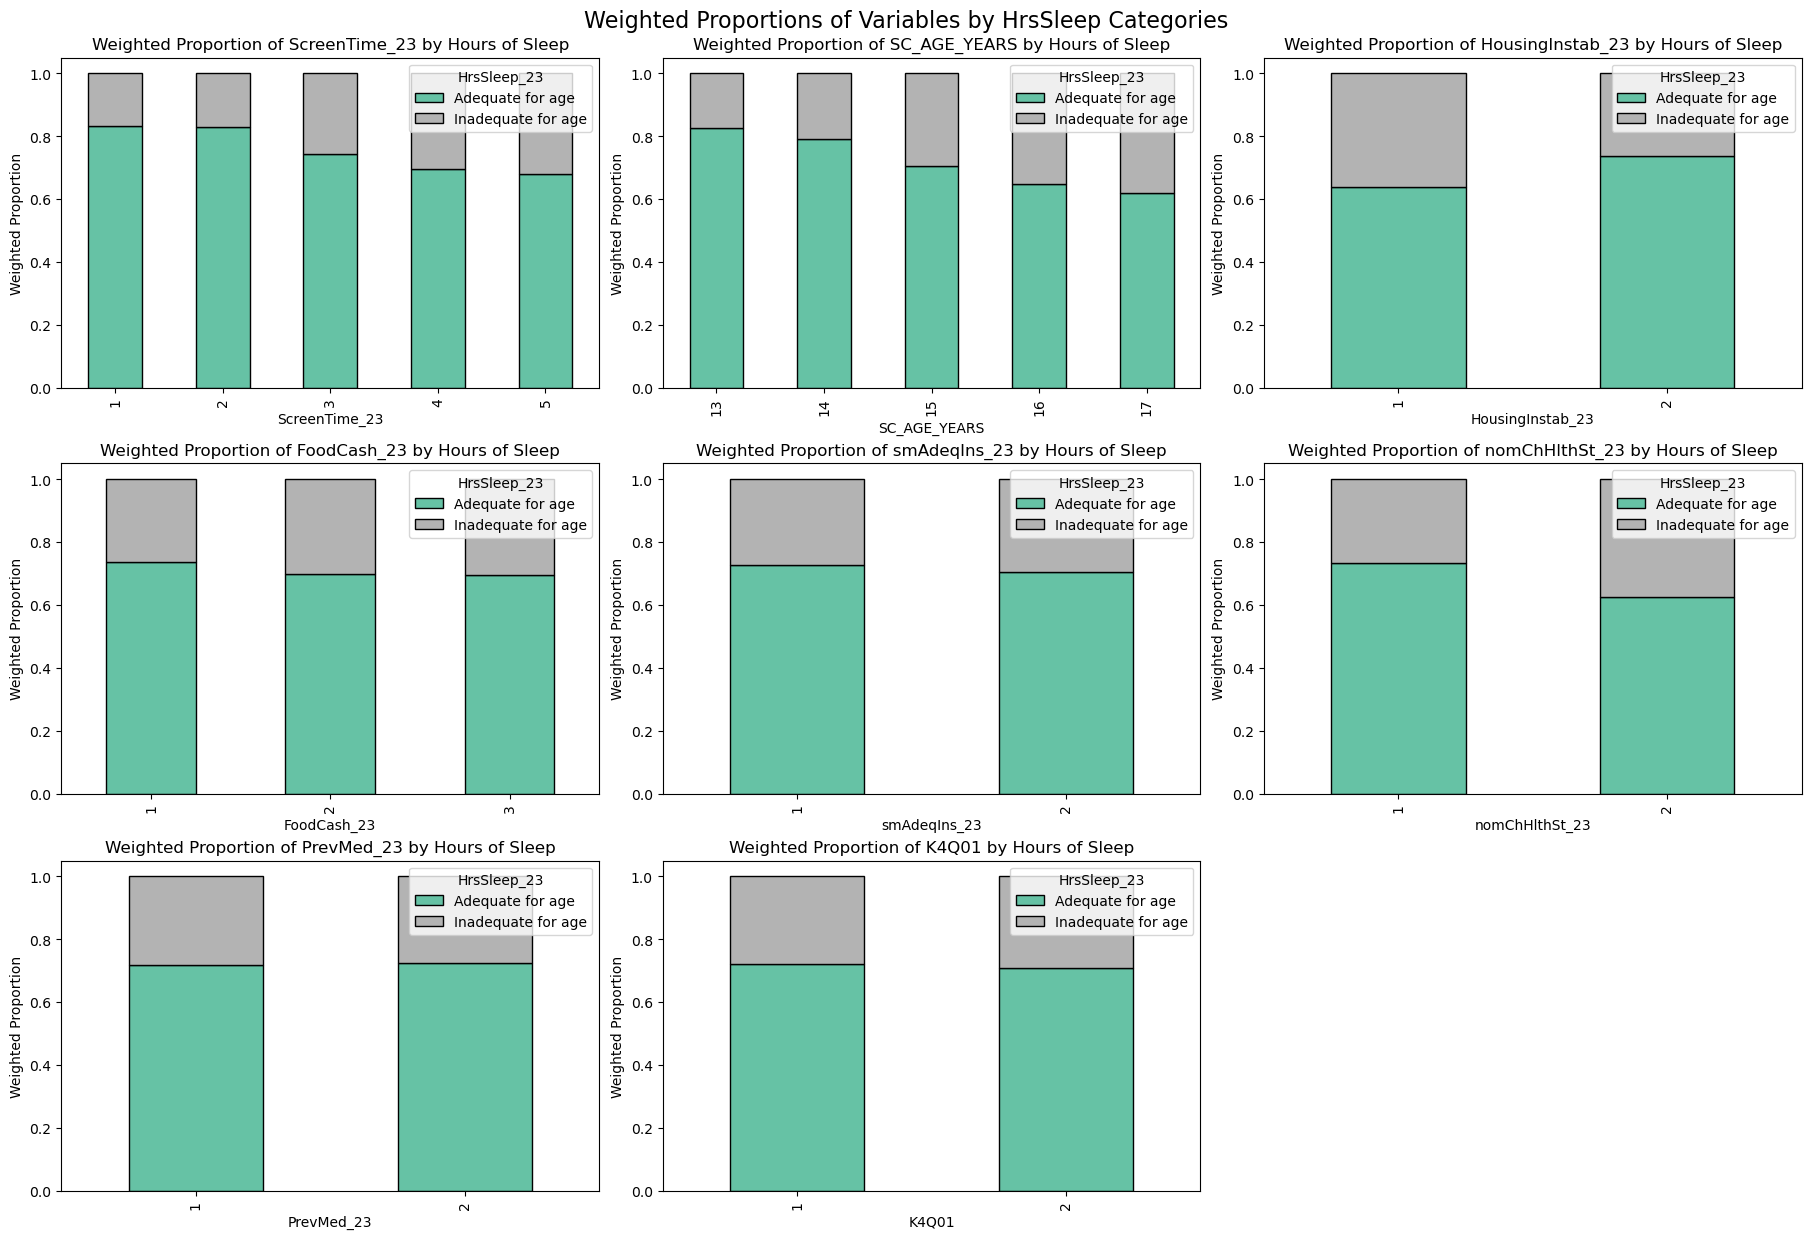

In [11]:
vars_to_plot = [
    'ScreenTime_23', 'SC_AGE_YEARS', 'HousingInstab_23',
    'FoodCash_23', 'smAdeqIns_23', 'nomChHlthSt_23', 'PrevMed_23', 'K4Q01'
]

n_vars = len(vars_to_plot)
cols = 3
rows = math.ceil(n_vars / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*4), constrained_layout=True)
axes = axes.flatten()

for i, var in enumerate(vars_to_plot):
    ax = axes[i]

    # Calculate weighted counts by variable and hue
    weighted_counts = (
        df_teen_rf
        .groupby([var, 'HrsSleep_labeled'], dropna=False)['FWC']
        .sum()
        .reset_index()
        .rename(columns={'FWC': 'weighted_count'})
    )

    # Calculate total weighted counts per variable value
    total_counts = (
        weighted_counts
        .groupby(var)['weighted_count']
        .sum()
        .reset_index()
        .rename(columns={'weighted_count': 'total_weighted_count'})
    )

    # Merge totals back to weighted_counts to calculate proportions
    merged = weighted_counts.merge(total_counts, on=var)
    merged['prop'] = merged['weighted_count'] / merged['total_weighted_count']

    # Pivot for plotting stacked bars
    pivot_df = merged.pivot(index=var, columns='HrsSleep_labeled', values='prop').fillna(0)

    # Sort index if possible (depends on your data type)
    pivot_df = pivot_df.sort_index()

    # Plot stacked bar
    pivot_df.plot(kind='bar', stacked=True, ax=ax, colormap='Set2', edgecolor='black')

    ax.set_title(f"Weighted Proportion of {var} by Hours of Sleep")
    ax.set_xlabel(var)
    ax.set_ylabel("Weighted Proportion")
    ax.legend(title='HrsSleep_23')

# Hide unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Weighted Proportions of Variables by HrsSleep Categories', fontsize=16, y=1.02)

# Save plot
plt.savefig('Q9_AdeqSleep_BNB_features.png', dpi=300, bbox_inches='tight')

plt.show()



### Convert categorical variables to dummy variables
- ScreenTime_23: 1, 2, 3, 4, 5
- Age: 13, 14, 15, 16, 17
- Housing instability: 1, 2
- Someone in family received food or cash in last 12 months: 1, 2, 3
- Adequate and continuous insurance: 1, 2
- Good health: 1, 2
- Preventative care: 1, 2
- Place for care (K4Q01): 1, 2

In [12]:
# Define your categorical columns
cat_cols = ['ScreenTime_23', 'SC_AGE_YEARS', 'HousingInstab_23',
            'FoodCash_23', 'smAdeqIns_23', 'nomChHlthSt_23', 'PrevMed_23', 'K4Q01']

# Instantiate the encoder
encoder = OneHotEncoder(drop=None, sparse_output=False, dtype=int)

# Fit and transform the categorical columns
encoded_array = encoder.fit_transform(df_teen_rf[cat_cols])

# Get feature names for the new one-hot columns
encoded_cols = encoder.get_feature_names_out(cat_cols)

# Create a DataFrame from the encoded array
encoded_df = pd.DataFrame(encoded_array, columns=encoded_cols, index=df_teen_rf.index)

# Drop the original categorical columns
df_teen_rf_dropped = df_teen_rf.drop(columns=cat_cols)

# Concatenate the original (reduced) dataframe with the encoded columns
df_teen_rf2 = pd.concat([df_teen_rf_dropped, encoded_df], axis=1)

In [13]:
df_teen_rf2['inadequate_sleep'].value_counts()

inadequate_sleep
0    11119
1     4272
Name: count, dtype: Int64

In [14]:
# Double check that distributions look right for the dummy variables
print(df_teen_rf['ScreenTime_23'].value_counts(normalize=True))
print (df_teen_rf2[['ScreenTime_23_1', 'ScreenTime_23_2', 'ScreenTime_23_3', 'ScreenTime_23_4', 'ScreenTime_23_5']].mean())
print(df_teen_rf['SC_AGE_YEARS'].value_counts(normalize=True))
print (df_teen_rf2[['SC_AGE_YEARS_13', 'SC_AGE_YEARS_14', 'SC_AGE_YEARS_15', 'SC_AGE_YEARS_16', 'SC_AGE_YEARS_17']].mean())
print(df_teen_rf['HousingInstab_23'].value_counts(normalize=True))
print (df_teen_rf2[['HousingInstab_23_1', 'HousingInstab_23_2']].mean())
print(df_teen_rf['FoodCash_23'].value_counts(normalize=True))
print (df_teen_rf2[['FoodCash_23_1', 'FoodCash_23_2', 'FoodCash_23_3']].mean())
print(df_teen_rf['smAdeqIns_23'].value_counts(normalize=True))
print (df_teen_rf2[['smAdeqIns_23_1', 'smAdeqIns_23_2']].mean())
print(df_teen_rf['nomChHlthSt_23'].value_counts(normalize=True))
print (df_teen_rf2[['nomChHlthSt_23_1', 'nomChHlthSt_23_2']].mean())
print(df_teen_rf['PrevMed_23'].value_counts(normalize=True))
print (df_teen_rf2[['PrevMed_23_1', 'PrevMed_23_2']].mean())
print(df_teen_rf['K4Q01'].value_counts(normalize=True))
print (df_teen_rf2[['K4Q01_1', 'K4Q01_2']].mean())

ScreenTime_23
5    0.377688
3    0.257033
4    0.256189
2    0.078682
1    0.030407
Name: proportion, dtype: float64
ScreenTime_23_1    0.030407
ScreenTime_23_2    0.078682
ScreenTime_23_3    0.257033
ScreenTime_23_4    0.256189
ScreenTime_23_5    0.377688
dtype: float64
SC_AGE_YEARS
16    0.224352
17    0.218959
15    0.201351
14    0.178091
13    0.177246
Name: proportion, dtype: float64
SC_AGE_YEARS_13    0.177246
SC_AGE_YEARS_14    0.178091
SC_AGE_YEARS_15    0.201351
SC_AGE_YEARS_16    0.224352
SC_AGE_YEARS_17    0.218959
dtype: float64
HousingInstab_23
2    0.862712
1    0.137288
Name: proportion, dtype: float64
HousingInstab_23_1    0.137288
HousingInstab_23_2    0.862712
dtype: float64
FoodCash_23
1    0.674030
2    0.260867
3    0.065103
Name: proportion, dtype: float64
FoodCash_23_1    0.674030
FoodCash_23_2    0.260867
FoodCash_23_3    0.065103
dtype: float64
smAdeqIns_23
1    0.637645
2    0.362355
Name: proportion, dtype: float64
smAdeqIns_23_1    0.637645
smAdeqIns_23_2  

Unlike Random Forest or logistic regression for Naive Bayes we keep all of the categories and do not drop a reference category.

In [15]:
# Displaying the data before splitting
features = ['ScreenTime_23_1','ScreenTime_23_2','ScreenTime_23_3','ScreenTime_23_4','ScreenTime_23_5',
            'SC_AGE_YEARS_13','SC_AGE_YEARS_14', 'SC_AGE_YEARS_15', 'SC_AGE_YEARS_16', 'SC_AGE_YEARS_17',
            'HousingInstab_23_1', 'HousingInstab_23_2', 'FoodCash_23_1', 'FoodCash_23_2', 'FoodCash_23_3',
            'smAdeqIns_23_1', 'smAdeqIns_23_2','nomChHlthSt_23_1','nomChHlthSt_23_2',
            'PrevMed_23_1','PrevMed_23_2', 'K4Q01_1', 'K4Q01_2']

target = 'inadequate_sleep'

FWC = df_teen_rf['FWC']

display(df_teen_rf2[features].head())
display(df_teen_rf2[target].head())

,ScreenTime_23_1,ScreenTime_23_2,ScreenTime_23_3,ScreenTime_23_4,ScreenTime_23_5,SC_AGE_YEARS_13,SC_AGE_YEARS_14,SC_AGE_YEARS_15,SC_AGE_YEARS_16,SC_AGE_YEARS_17,...,FoodCash_23_2,FoodCash_23_3,smAdeqIns_23_1,smAdeqIns_23_2,nomChHlthSt_23_1,nomChHlthSt_23_2,PrevMed_23_1,PrevMed_23_2,K4Q01_1,K4Q01_2
1,0,0,0,0,1,0,1,0,0,0,...,1,0,1,0,1,0,1,0,1,0
2,0,0,0,1,0,0,0,0,0,1,...,1,0,1,0,0,1,1,0,1,0
5,0,0,1,0,0,0,1,0,0,0,...,0,1,1,0,1,0,0,1,0,1
6,0,0,0,1,0,0,0,1,0,0,...,1,0,1,0,1,0,1,0,1,0
9,0,0,0,0,1,0,0,0,1,0,...,0,0,1,0,1,0,1,0,1,0


1    0
2    0
5    0
6    0
9    1
Name: inadequate_sleep, dtype: Int64

In [16]:
# Splitting the dataset into the Training set and Test set
# Add stratify=y to maintain class-balanced split, maintain label proportions and improve reliability

X_train, X_test, y_train, y_test, FWC_train, FWC_test = train_test_split(df_teen_rf2[features],df_teen_rf2[target],FWC, 
                                                                         test_size=0.3,random_state=4567, stratify=df_teen_rf2[target])

In [17]:
# For training set
train_counts = y_train.value_counts()
train_percentages = y_train.value_counts(normalize=True) * 100
train_summary = pd.DataFrame({'Count': train_counts, 'Percentage': train_percentages.round(2)})
print("Training Set Class Distribution:")
display(train_summary)

# For test set
test_counts = y_test.value_counts()
test_percentages = y_test.value_counts(normalize=True) * 100
test_summary = pd.DataFrame({'Count': test_counts, 'Percentage': test_percentages.round(2)})
print("Test Set Class Distribution:")
display(test_summary)

Training Set Class Distribution:


,Count,Percentage
inadequate_sleep,,
0,7783,72.25
1,2990,27.75


Test Set Class Distribution:


,Count,Percentage
inadequate_sleep,,
0,3336,72.24
1,1282,27.76


In [18]:
# display the data after splitting

# Training set
display(pd.DataFrame(X_train).head())
display(pd.DataFrame(y_train).head())

# Test set
display(pd.DataFrame(X_test).head())
display(pd.DataFrame(y_test).head())
 

,ScreenTime_23_1,ScreenTime_23_2,ScreenTime_23_3,ScreenTime_23_4,ScreenTime_23_5,SC_AGE_YEARS_13,SC_AGE_YEARS_14,SC_AGE_YEARS_15,SC_AGE_YEARS_16,SC_AGE_YEARS_17,...,FoodCash_23_2,FoodCash_23_3,smAdeqIns_23_1,smAdeqIns_23_2,nomChHlthSt_23_1,nomChHlthSt_23_2,PrevMed_23_1,PrevMed_23_2,K4Q01_1,K4Q01_2
33411,0,0,1,0,0,0,1,0,0,0,...,0,0,1,0,0,1,1,0,0,1
3617,0,0,0,0,1,0,0,0,1,0,...,0,0,1,0,1,0,1,0,1,0
43104,0,0,1,0,0,0,1,0,0,0,...,0,0,1,0,1,0,0,1,0,1
51205,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,1,0,1,0,1,0
27558,0,0,1,0,0,1,0,0,0,0,...,1,0,1,0,1,0,1,0,1,0


,inadequate_sleep
33411,0
3617,1
43104,1
51205,0
27558,0


,ScreenTime_23_1,ScreenTime_23_2,ScreenTime_23_3,ScreenTime_23_4,ScreenTime_23_5,SC_AGE_YEARS_13,SC_AGE_YEARS_14,SC_AGE_YEARS_15,SC_AGE_YEARS_16,SC_AGE_YEARS_17,...,FoodCash_23_2,FoodCash_23_3,smAdeqIns_23_1,smAdeqIns_23_2,nomChHlthSt_23_1,nomChHlthSt_23_2,PrevMed_23_1,PrevMed_23_2,K4Q01_1,K4Q01_2
5896,0,0,0,0,1,0,0,1,0,0,...,0,0,1,0,1,0,1,0,1,0
30050,0,0,0,0,1,1,0,0,0,0,...,0,1,1,0,1,0,1,0,1,0
23393,0,0,0,0,1,0,1,0,0,0,...,1,0,1,0,1,0,1,0,1,0
18335,0,0,1,0,0,0,0,0,1,0,...,0,0,1,0,1,0,0,1,1,0
26592,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,1,0,1,0,1,0


,inadequate_sleep
5896,0
30050,0
23393,0
18335,0
26592,0


In [19]:
# Do not need to scale the data for a naive Bayes analysis
# Displaying the training set

display(pd.DataFrame(X_train).head())

,ScreenTime_23_1,ScreenTime_23_2,ScreenTime_23_3,ScreenTime_23_4,ScreenTime_23_5,SC_AGE_YEARS_13,SC_AGE_YEARS_14,SC_AGE_YEARS_15,SC_AGE_YEARS_16,SC_AGE_YEARS_17,...,FoodCash_23_2,FoodCash_23_3,smAdeqIns_23_1,smAdeqIns_23_2,nomChHlthSt_23_1,nomChHlthSt_23_2,PrevMed_23_1,PrevMed_23_2,K4Q01_1,K4Q01_2
33411,0,0,1,0,0,0,1,0,0,0,...,0,0,1,0,0,1,1,0,0,1
3617,0,0,0,0,1,0,0,0,1,0,...,0,0,1,0,1,0,1,0,1,0
43104,0,0,1,0,0,0,1,0,0,0,...,0,0,1,0,1,0,0,1,0,1
51205,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,1,0,1,0,1,0
27558,0,0,1,0,0,1,0,0,0,0,...,1,0,1,0,1,0,1,0,1,0


In [20]:
# Implementing naive Bayes classifier

classifier = BernoulliNB(alpha=1.0) # Using default alpha for smoothing
classifier.fit(X_train, y_train, sample_weight = FWC_train)

#X_train - the training features whose values may induce insurance coverage thresholds
#y_train - the coorresponding targer variable (0 or 1) for the training features

BernoulliNB()

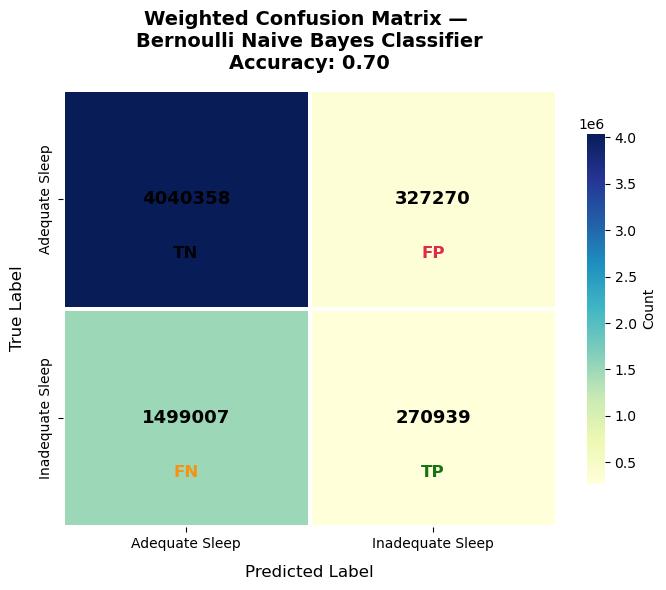

In [21]:
# Generating the confusion matrix

# Predictions
preds = classifier.predict(X_test)

# Compute weighted confusion matrix and weighted accuracy
conf_df = pd.DataFrame({
    'y_true': y_test,
    'y_pred': preds,
    'weight': FWC_test
})

# Group by true and predicted labels and sum weights
weighted_cm = conf_df.groupby(['y_true', 'y_pred'])['weight'].sum().unstack(fill_value=0)

# Ensure matrix shape is 2x2
weighted_cm = weighted_cm.reindex(index=[0,1], columns=[0,1], fill_value=0).values.astype(int)

acc = accuracy_score(y_test, preds, sample_weight=FWC_test)

# Class labels
labels = ["Adequate Sleep", "Inadequate Sleep"]

# Plot setup
plt.figure(figsize=(7,6))
ax = sns.heatmap(weighted_cm, annot=True, fmt='d',
                 cmap='YlGnBu',
                 linewidths=1.5, linecolor='white',
                 xticklabels=labels, yticklabels=labels,
                 cbar_kws={'shrink':0.8, 'label':'Count'},
                 annot_kws={'size':13, 'weight':'bold', 'color':'black'})

plt.title(f"Weighted Confusion Matrix — \nBernoulli Naive Bayes Classifier\nAccuracy: {acc:.2f}",
          fontsize=14, weight='bold', pad=15)
plt.xlabel("Predicted Label", fontsize=12, labelpad=10)
plt.ylabel("True Label", fontsize=12, labelpad=10)

# Label coordinates (slightly below numeric counts)
offset_y = 0.25  # small downward shift from center

# Overlay TN / FP / FN / TP *below* the numbers
for i in range(weighted_cm.shape[0]):
    for j in range(weighted_cm.shape[1]):
        if i == 0 and j == 0:
            label, color = "TN", "black"
        elif i == 0 and j == 1:
            label, color = "FP", "crimson"
        elif i == 1 and j == 0:
            label, color = "FN", "darkorange"
        else:
            label, color = "TP", "darkgreen"

        ax.text(j + 0.5, i + 0.5 + offset_y, label,
                color=color, fontsize=12, weight='bold',
                ha='center', va='center', alpha=0.9)

plt.tight_layout()

# Save plot
plt.savefig('Q9_AdeqSleep_BNB_CM.png', dpi=300, bbox_inches='tight')

plt.show()

In [22]:
print(weighted_cm)

[[4040358  327270]
 [1499007  270939]]


In [23]:
# Accuracy, F1 Score and Recall Score

# See final program for text on what these are

accuracy = accuracy_score(y_test, preds, sample_weight=FWC_test)
f1 = f1_score(y_test, preds, sample_weight=FWC_test)
recall = recall_score(y_test, preds, sample_weight=FWC_test)

print(f'Accuracy: {accuracy:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'Recall: {recall:.2f}')

Accuracy: 0.70
F1 Score: 0.23
Recall: 0.15


In [24]:
# Predict the test set probabilities of the positive class
y_pred_proba_rf = classifier.predict_proba(X_test)[:,1]
test_roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf, sample_weight=FWC_test)
# Print test_roc_auc
print('Test set ROC AUC score: {:.3f}'.format(test_roc_auc_rf))

Test set ROC AUC score: 0.658


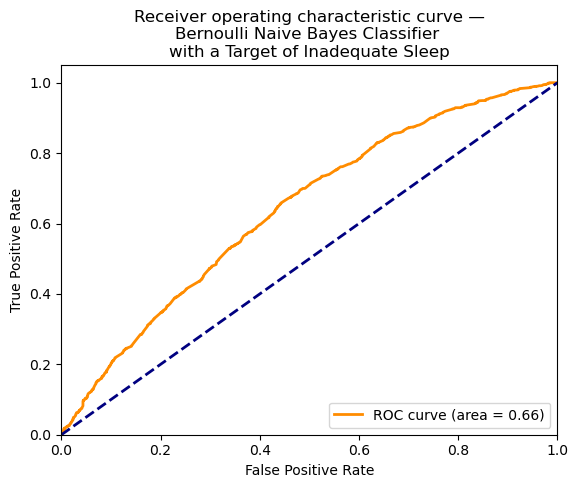

In [25]:
## ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_rf)

lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % test_roc_auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve —\nBernoulli Naive Bayes Classifier \nwith a Target of Inadequate Sleep')
plt.legend(loc="lower right")

# Save plot
plt.savefig('Q9_AdeqSleep_BNB_ROC.png', dpi=300, bbox_inches='tight')

plt.show()

In [26]:
print (classifier.get_params())

{'alpha': 1.0, 'binarize': 0.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': True}


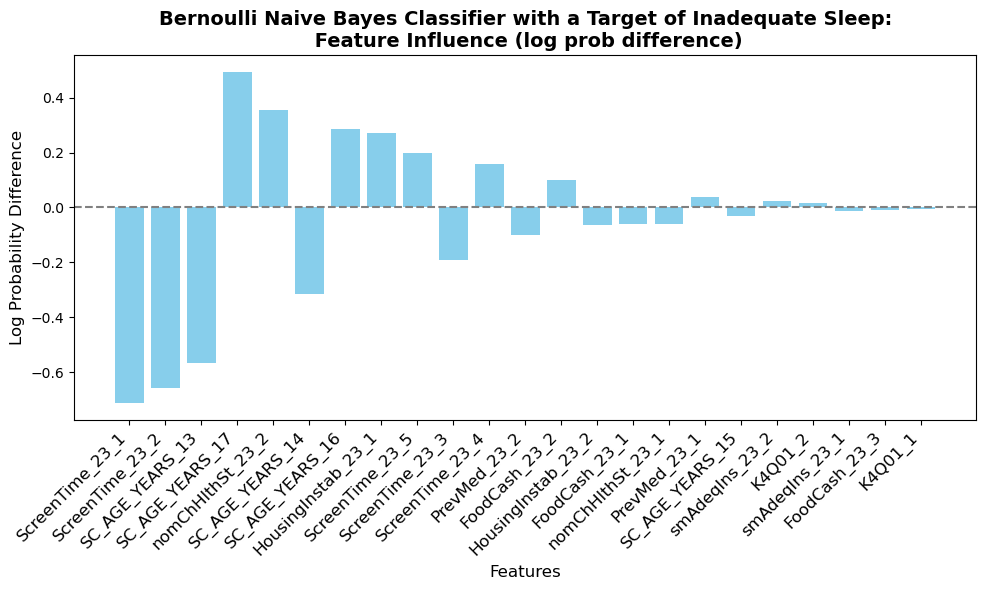

In [27]:
#BernoulliNB does not have an attribute for feature importance
#However, can look at log probabilities 
#A positive score means the feature is more associated with class 1 (inadequate sleep).
#A negative score means it's more associated with class 0 (adequate sleep).
#The magnitude tells you how influential that feature is, but it’s not exactly the same as impurity-based importance.

# Get the log-probabilities for each feature per class
log_probs = classifier.feature_log_prob_

# Compute the difference between classes (e.g., log odds for class 1 vs 0)
feature_scores = log_probs[1] - log_probs[0]  # or vice versa

# Sort by importance (absolute log-odds)
indices = np.argsort(np.abs(feature_scores))[::-1]

# Visualize
plt.figure(figsize=(10, 6))
plt.title("Bernoulli Naive Bayes Classifier with a Target of Inadequate Sleep:\n Feature Influence (log prob difference)", fontsize=14, weight='bold')
plt.bar(range(len(indices)), feature_scores[indices], align='center', color='skyblue')
plt.xticks(range(len(indices)), [features[i] for i in indices], rotation=45, ha='right', fontsize=12)
plt.xlabel("Features", fontsize=12)
plt.ylabel("Log Probability Difference", fontsize=12)
plt.axhline(0, color='grey', linestyle='--')
plt.tight_layout()

# Save plot
plt.savefig('Q9_AdeqSleep_BNB_LogDiff.png', dpi=300, bbox_inches='tight')

plt.show()

### Partial dependence plots 
Look for the directionality of the results.

Partial dependence plots show the dependence between the target function and a set of ‘target’ features, marginalizing over the values of all other features (the complement features). 

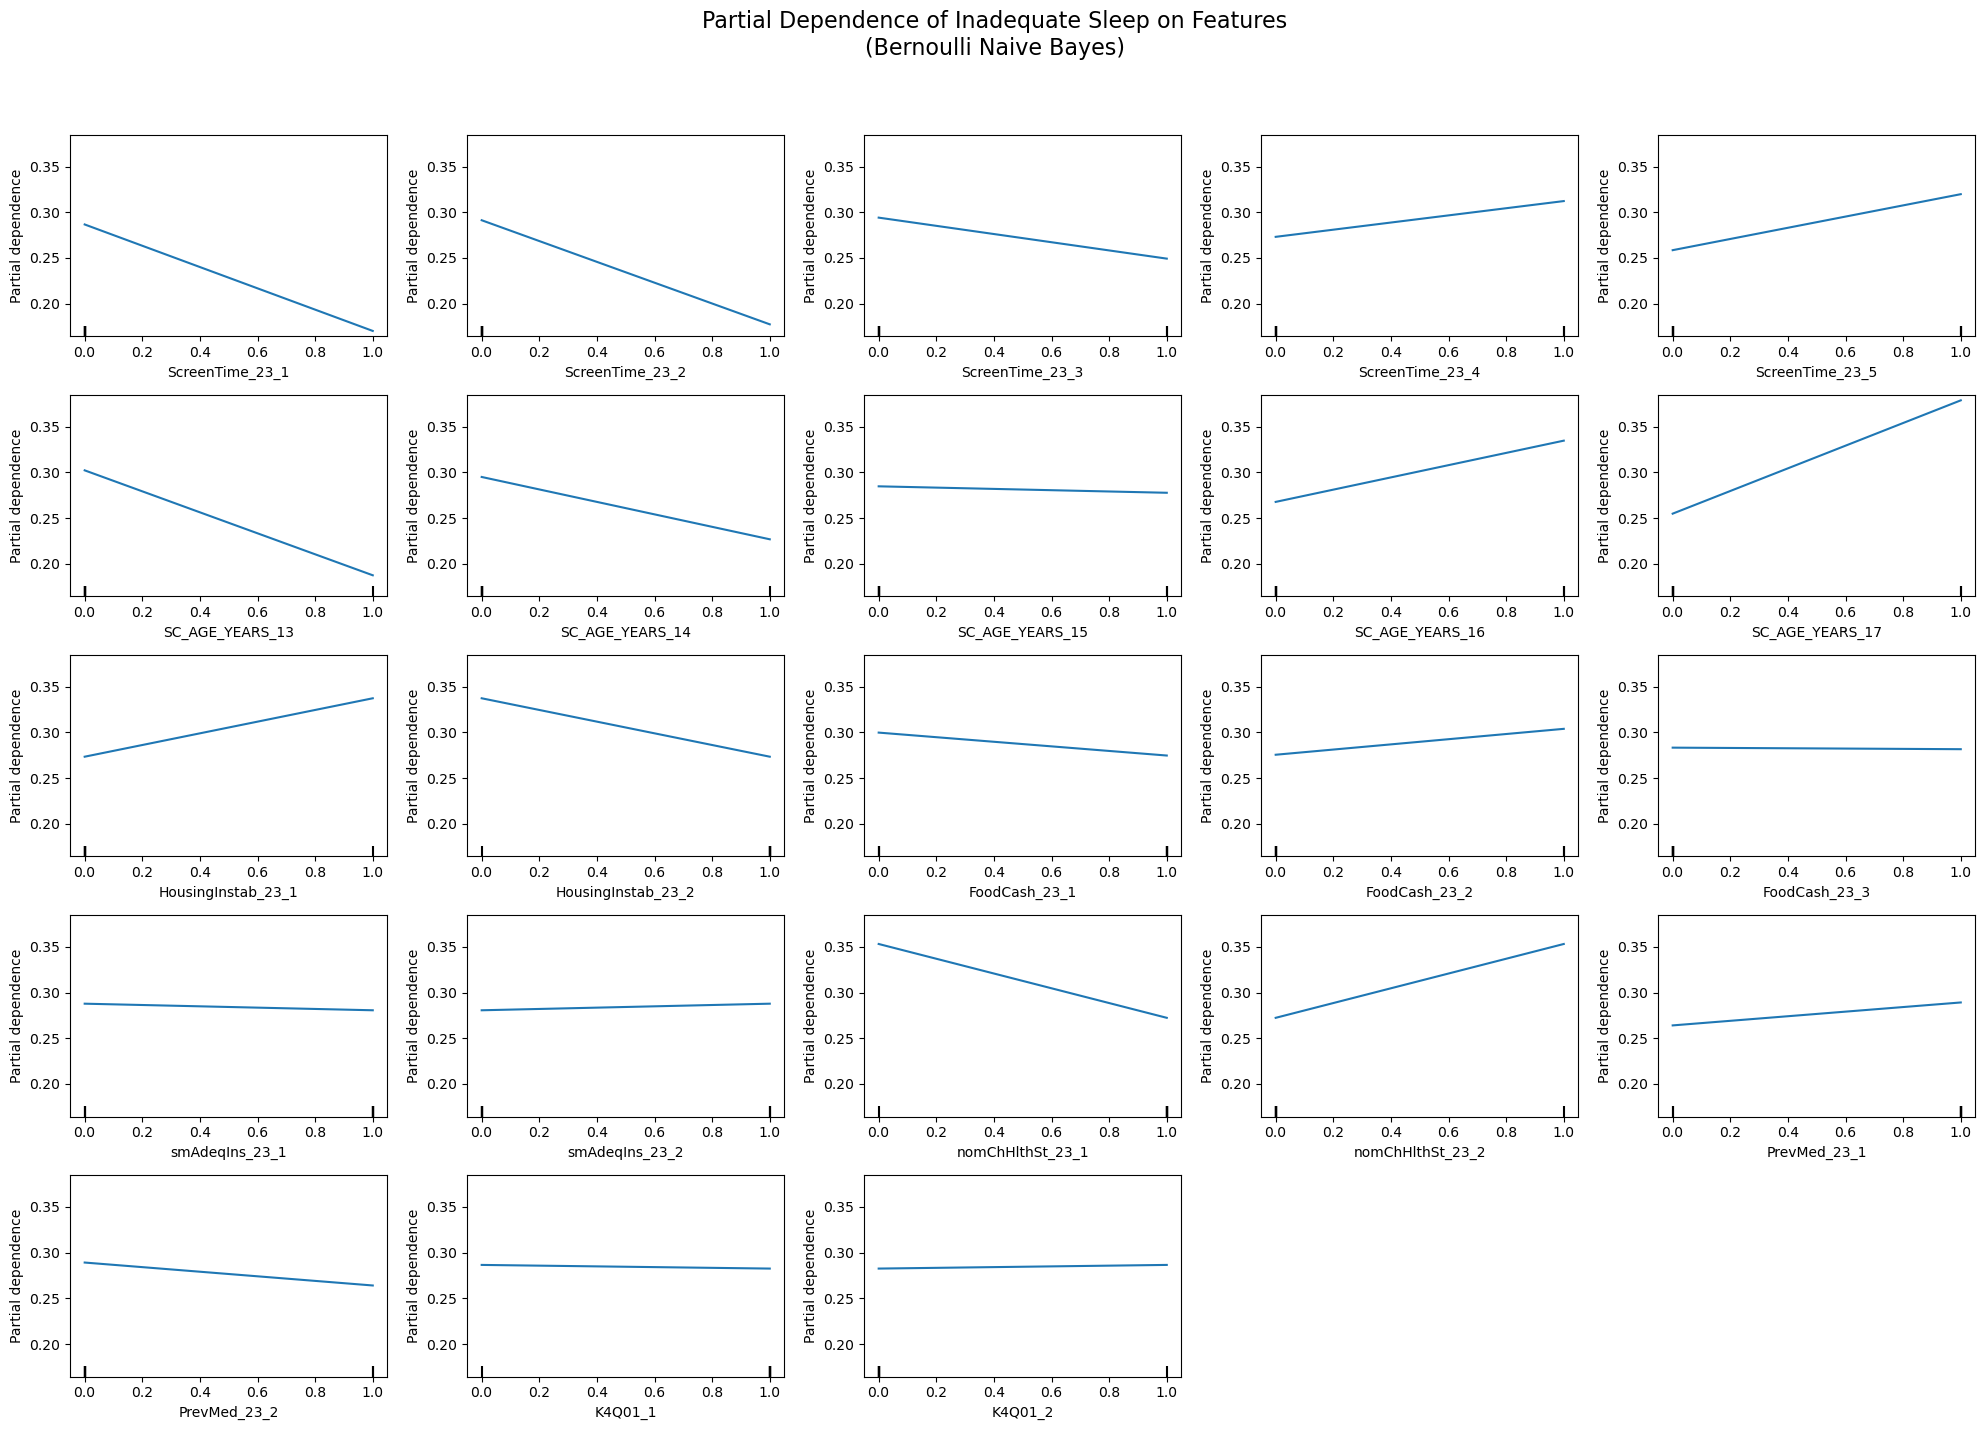

In [28]:
# Make sure 'features' is a list of 23 features (names or indices)
n_features = len(features)
ncols = 5
nrows = int(np.ceil(n_features / ncols))

# Create enough subplots (will likely have a few extra)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 4, nrows * 3))

# Flatten the axes
ax = ax.flatten()

# Plot partial dependence
PartialDependenceDisplay.from_estimator(classifier, X_train, features, ax=ax[:n_features])

# Remove unused axes (if any)
for i in range(n_features, len(ax)):
    fig.delaxes(ax[i])

# Set title and layout
fig.suptitle('Partial Dependence of Inadequate Sleep on Features\n(Bernoulli Naive Bayes)', fontsize=16)
fig.subplots_adjust(wspace=0.4, hspace=0.6)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [29]:
#Test if a different threshold would result in better accuracy,recall,F1-score
probs = classifier.predict_proba(X_test)[:, 1]

for t in [0.5, 0.4, 0.35, 0.3, 0.25]:
    preds_t = (probs >= t).astype(int)
    print(f"Threshold: {t}")
    print("Accuracy:", accuracy_score(y_test, preds_t, sample_weight=FWC_test))
    print("Recall:", recall_score(y_test, preds_t, sample_weight=FWC_test))
    print("F1:", f1_score(y_test, preds_t, sample_weight=FWC_test))
    print("-" * 30)

#a threshold of 0.35 produces better recall and f1-score

Threshold: 0.5
Accuracy: 0.7024431758488879
Recall: 0.15307778488080856
F1: 0.22881893910629264
------------------------------
Threshold: 0.4
Accuracy: 0.6860319176711162
Recall: 0.31559300763208115
F1: 0.3669854908968564
------------------------------
Threshold: 0.35
Accuracy: 0.6661610289515518
Recall: 0.41683621651826747
F1: 0.41865468022417074
------------------------------
Threshold: 0.3
Accuracy: 0.6273578148411276
Recall: 0.5210778833911851
F1: 0.4464431762236181
------------------------------
Threshold: 0.25
Accuracy: 0.5960870095229795
Recall: 0.6982929086060392
F1: 0.4992765102462831
------------------------------
